In [1]:
from collections import defaultdict
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import scvelo as scv
#import velocyto as vcy
from os import listdir
from os.path import isfile, join
import glob
from collections import Counter
import loompy as lp
import numba
import llvmlite
import scipy.sparse

# import mnnpy
from matplotlib import colors

In [2]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [3]:
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0rc0 python-igraph==0.9.6 louvain==0.7.0 pynndescent==0.5.4


In [4]:
pack_list = [numba,llvmlite,lp,pd,sns,scv]
for pack in pack_list:
    print(str(pack), pack.__version__)
    

<module 'numba' from 'C:\\Users\\giovanni\\anaconda3\\envs\\python39\\lib\\site-packages\\numba\\__init__.py'> 0.54.0
<module 'llvmlite' from 'C:\\Users\\giovanni\\anaconda3\\envs\\python39\\lib\\site-packages\\llvmlite\\__init__.py'> 0.37.0
<module 'loompy' from 'C:\\Users\\giovanni\\AppData\\Roaming\\Python\\Python39\\site-packages\\loompy\\__init__.py'> 3.0.6
<module 'pandas' from 'C:\\Users\\giovanni\\anaconda3\\envs\\python39\\lib\\site-packages\\pandas\\__init__.py'> 1.3.3
<module 'seaborn' from 'C:\\Users\\giovanni\\AppData\\Roaming\\Python\\Python39\\site-packages\\seaborn\\__init__.py'> 0.11.2
<module 'scvelo' from 'C:\\Users\\giovanni\\AppData\\Roaming\\Python\\Python39\\site-packages\\scvelo\\__init__.py'> 0.2.4


In [5]:
scv.set_figure_params('scanpy')  # for beautified visualization

In [6]:
sc.set_figure_params(dpi_save=500, frameon=True,
                     vector_friendly=True, fontsize=14,
                     figsize=None, color_map=None, format='pdf',
                     facecolor=None, transparent=True, ipython_format='png2x')


In [7]:
def get_cluster_proportions(adata,
                            cluster_key="cluster_final",
                            sample_key="replicate",
                            drop_values=None):

    
    adata_tmp = adata.copy()
    sizes = adata_tmp.obs.groupby([cluster_key, sample_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index() 
    props = props.pivot(columns=sample_key, index=cluster_key).T
    props.index = props.index.droplevel(0)
    props.fillna(0, inplace=True)
    
    if drop_values is not None:
        for drop_value in drop_values:
            props.drop(drop_value, axis=0, inplace=True)
    return props


def plot_cluster_proportions(cluster_props, 
                             cluster_palette=None,
                             xlabel_rotation=1): 
    fig, ax = plt.subplots(dpi=600, figsize=(6, 24))
    fig.patch.set_facecolor("white")
    
    cmap = None
    if cluster_palette is not None:
        cmap = sns.palettes.blend_palette(
            cluster_palette, 
            n_colors=len(cluster_palette), 
            as_cmap=True)
   
    cluster_props.plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        legend=None, 
        colormap=cmap
    )
    
    ax.legend(bbox_to_anchor=(1.01, 1), frameon=False, title="Cell Type")
    sns.despine(fig, ax)
    ax.tick_params(axis="x", rotation=xlabel_rotation)
    ax.set_xlabel(cluster_props.index.name.capitalize())
    ax.set_ylabel("Proportion")
    fig.tight_layout()
    
    return fig

In [8]:
filtered_symbol_unique = pd.read_csv("../geneid_symbol_filtered_unique.csv").set_index("gene_id")
filtered_symbol_unique

,symbol
gene_id,
AMEX60DD003449,AMEX60DD003449
AMEX60DD005685,AMEX60DD005685
AMEX60DD009250,AMEX60DD009250
AMEX60DD022557,AMEX60DD022557
AMEX60DD025407,HNRNPUL2
...,...
ERCC-00041,ERCC.00041
ERCC-00130,ERCC.00130
HoxA11_E1,X


**Macrophages**

In [9]:
path = '../Seurat/integrated_Macro_Blastema_Sen.h5ad'
AxoMac = sc.read_h5ad(path)

In [10]:
AxoMac

AnnData object with n_obs × n_vars = 623 × 99218
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'seurat_clusters', 'dataset', 'cellType', 'integrated_snn_res.0.4'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

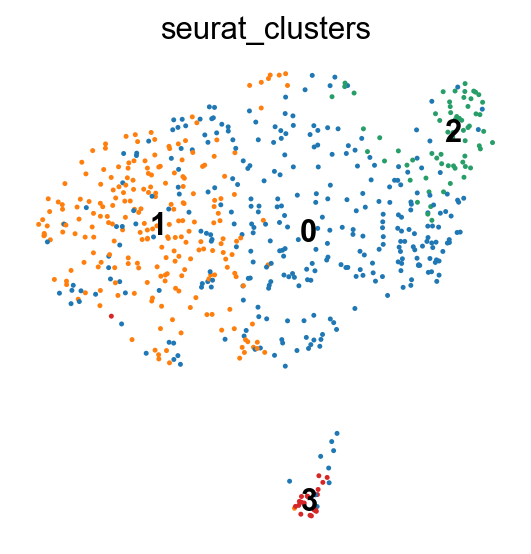

In [11]:
sc.pl.umap(AxoMac, color=['seurat_clusters'], legend_loc='on data', size=20, frameon=False)

In [12]:
AxoMac.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,SCT_snn_res.1,seurat_clusters,dataset,cellType,integrated_snn_res.0.4
pal1_01_A01,pal,177896.0,2921,217059.0,2916,4,0,Yu,Senescent,0
pal1_01_A17,pal,138990.0,2398,216259.0,2379,4,0,Yu,Senescent,0
pal1_01_A22,pal,421092.0,5408,209383.0,4718,1,1,Yu,Senescent,1
pal1_01_A18,pal,230810.0,4011,220244.0,4001,4,0,Yu,Senescent,0
pal2_01_B08,pal,280694.0,5004,221082.0,4986,4,0,Yu,Senescent,0
...,...,...,...,...,...,...,...,...,...,...
Blastema_377_02_P20,Blastema,1007647.0,2338,1265212.0,2302,1,0,Macrophage,NA,0
Blastema_378_02_P21,Blastema,1857106.0,2049,1215047.0,2046,0,0,Macrophage,NA,0
Blastema_379_02_P22,Blastema,1321607.0,2235,1243204.0,2196,0,0,Macrophage,NA,0
Blastema_380_02_P23,Blastema,952882.0,2746,1265844.0,2692,1,0,Macrophage,NA,0


In [13]:
AxoMac.var

,name
AMEX60DD000001,AMEX60DD000001
AMEX60DD000002,AMEX60DD000002
AMEX60DD000003,AMEX60DD000003
AMEX60DD000004,AMEX60DD000004
AMEX60DD000005,AMEX60DD000005
...,...
ERCC-00164,ERCC-00164
ERCC-00165,ERCC-00165
ERCC-00168,ERCC-00168
ERCC-00170,ERCC-00170


In [14]:
## Filter by repeats
new_vars = AxoMac.var.merge(filtered_symbol_unique, how='inner', left_index=True, right_index=True)
AxoMac = AxoMac[:,list(new_vars.index)]
AxoMac.var = new_vars
AxoMac.var.set_index("symbol", inplace=True)
AxoMac.var_names_make_unique()

In [15]:
AxoMac.var_names_make_unique()

In [16]:
AxoMac.var

,name
symbol,
ZFP37,AMEX60DD000001
LOC114595135.4,AMEX60DD000002
LOC115462503,AMEX60DD000004
AMEX60DD000005,AMEX60DD000005
LOC115464621,AMEX60DD000006
...,...
ERCC.00164,ERCC-00164
ERCC.00165,ERCC-00165
ERCC.00168,ERCC-00168


In [17]:
sc.pp.neighbors(AxoMac, n_neighbors=20, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [18]:
sc.tl.draw_graph(AxoMac)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:06)


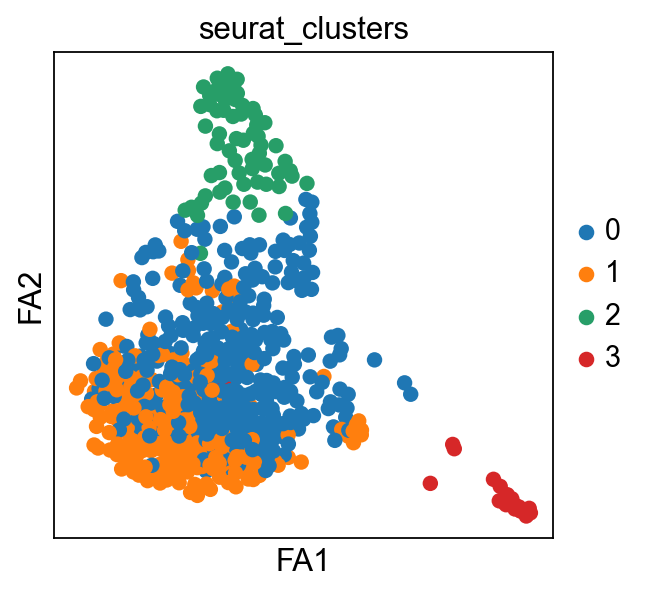

In [19]:
sc.pl.draw_graph(AxoMac, color=['seurat_clusters'])

In [20]:
sc.pp.normalize_total(AxoMac, target_sum=1e4)
sc.pp.log1p(AxoMac)

normalizing counts per cell
    finished (0:00:00)


ranking genes
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


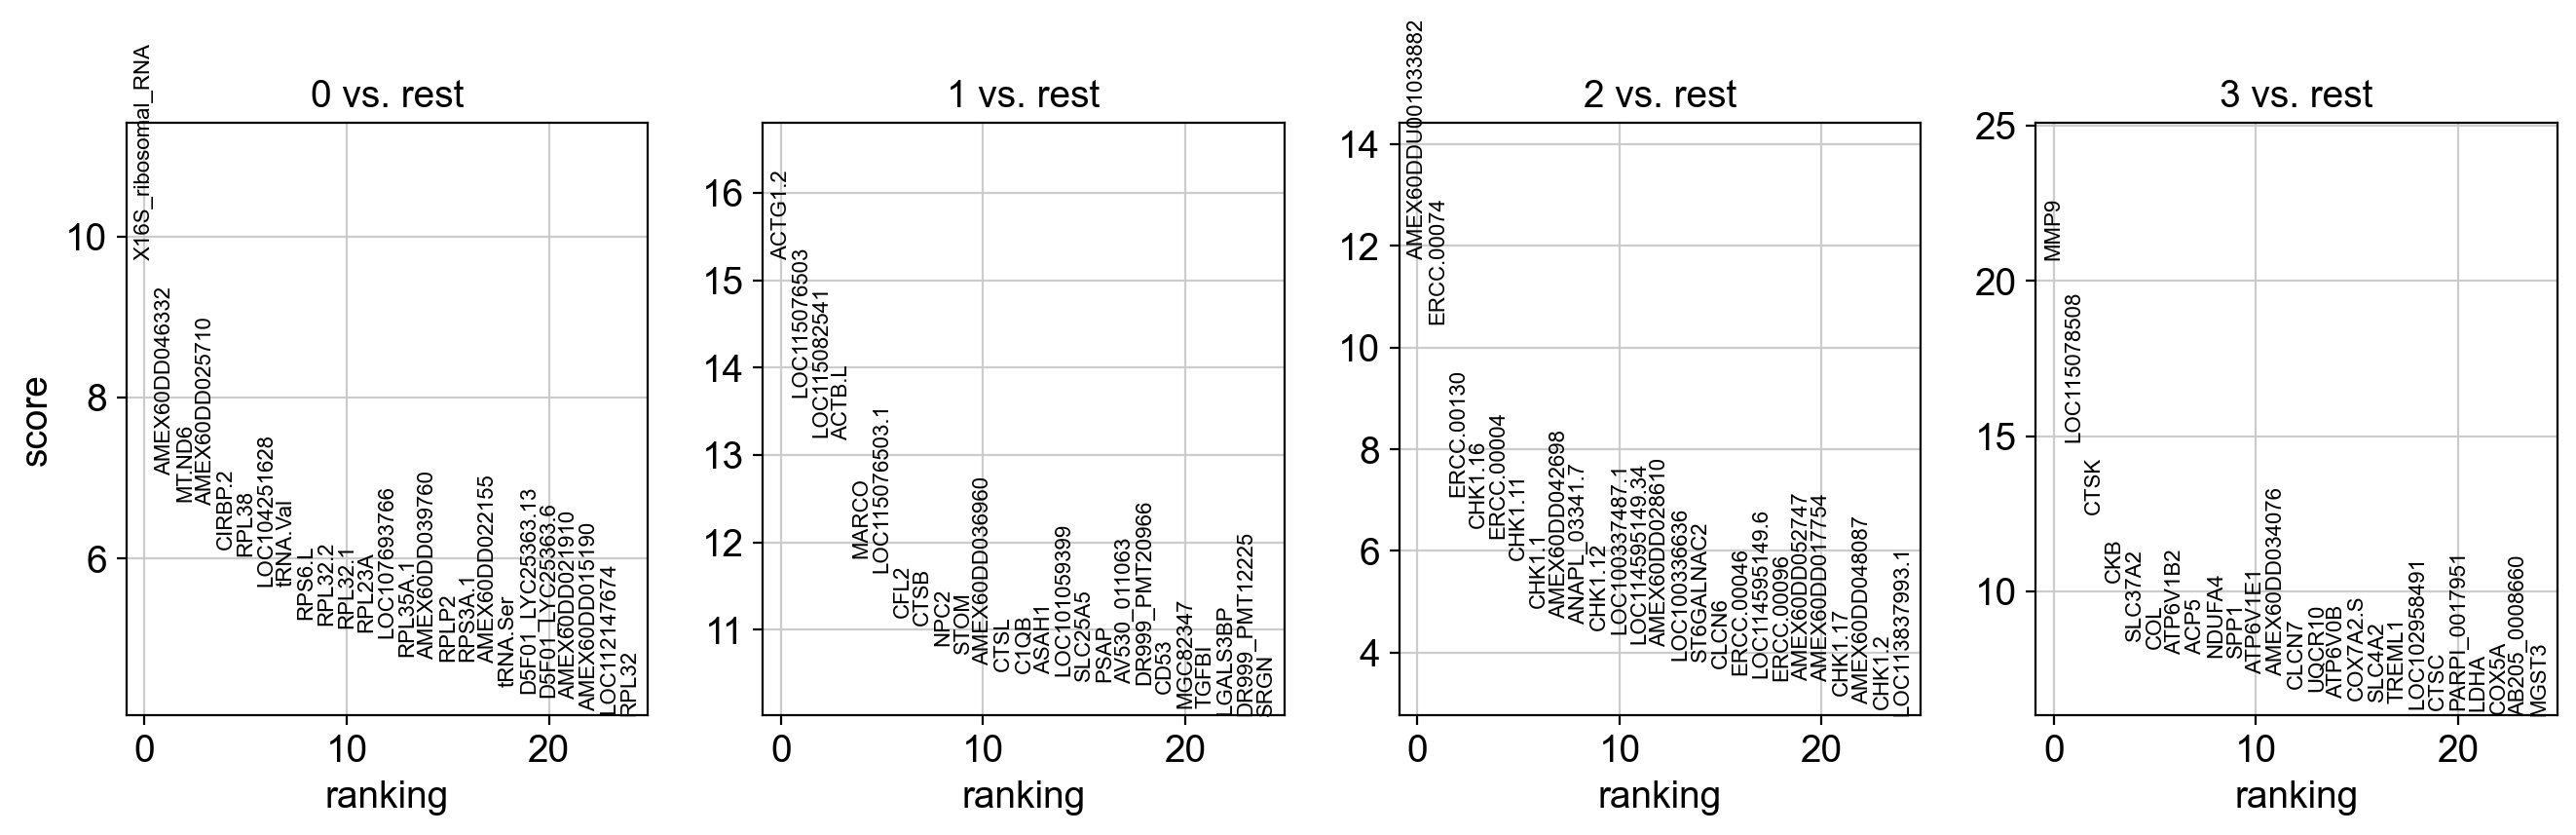

In [21]:
# Find marker genes
sc.settings.set_figure_params(dpi=100)

sc.tl.rank_genes_groups(AxoMac, 'seurat_clusters', method='t-test_overestim_var', key_added='t-test')
sc.pl.rank_genes_groups(AxoMac, n_genes=25, sharey=False, key='t-test')
sc.settings.set_figure_params(dpi=80)

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


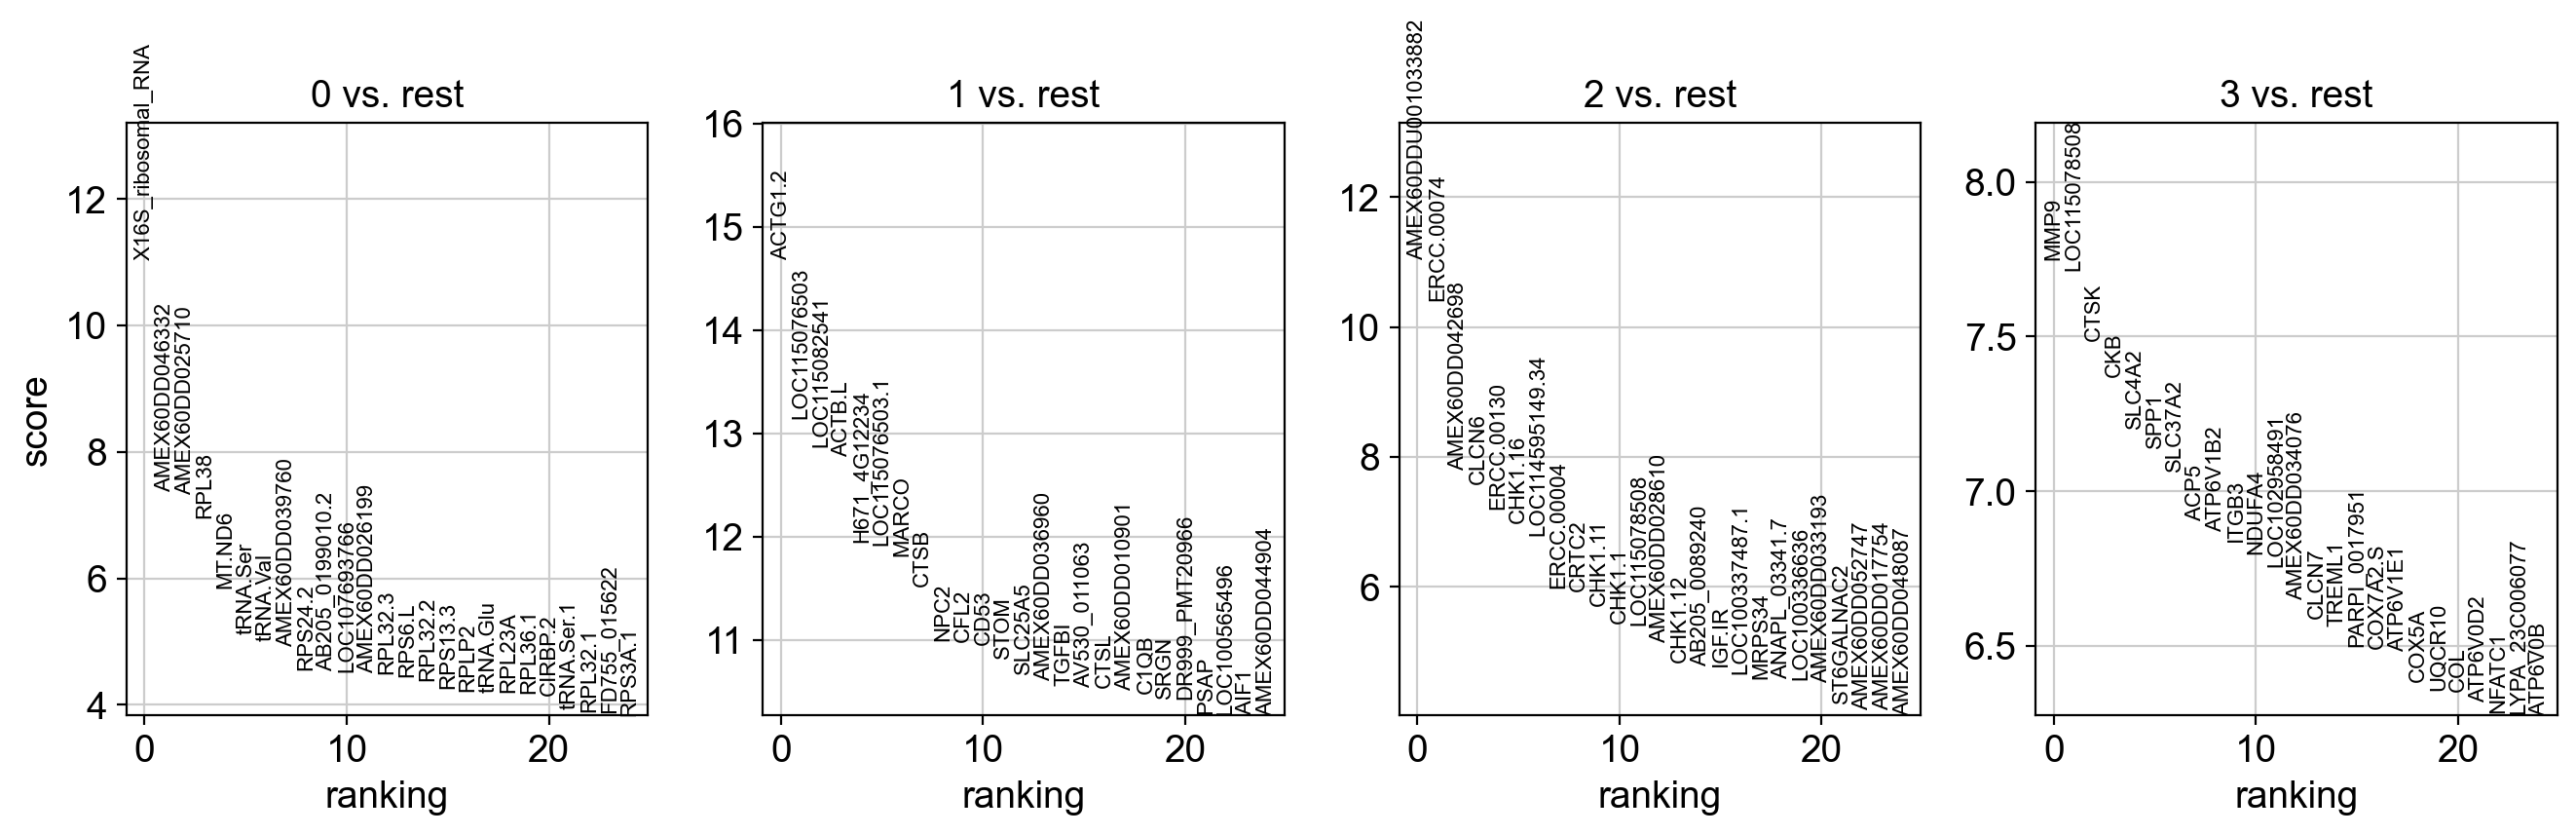

In [22]:
# Find marker genes
sc.settings.set_figure_params(dpi=100)

sc.tl.rank_genes_groups(AxoMac, 'seurat_clusters', method='wilcoxon', key_added='wilcoxon')
sc.pl.rank_genes_groups(AxoMac, n_genes=25, sharey=False, key='wilcoxon')
sc.settings.set_figure_params(dpi=80)

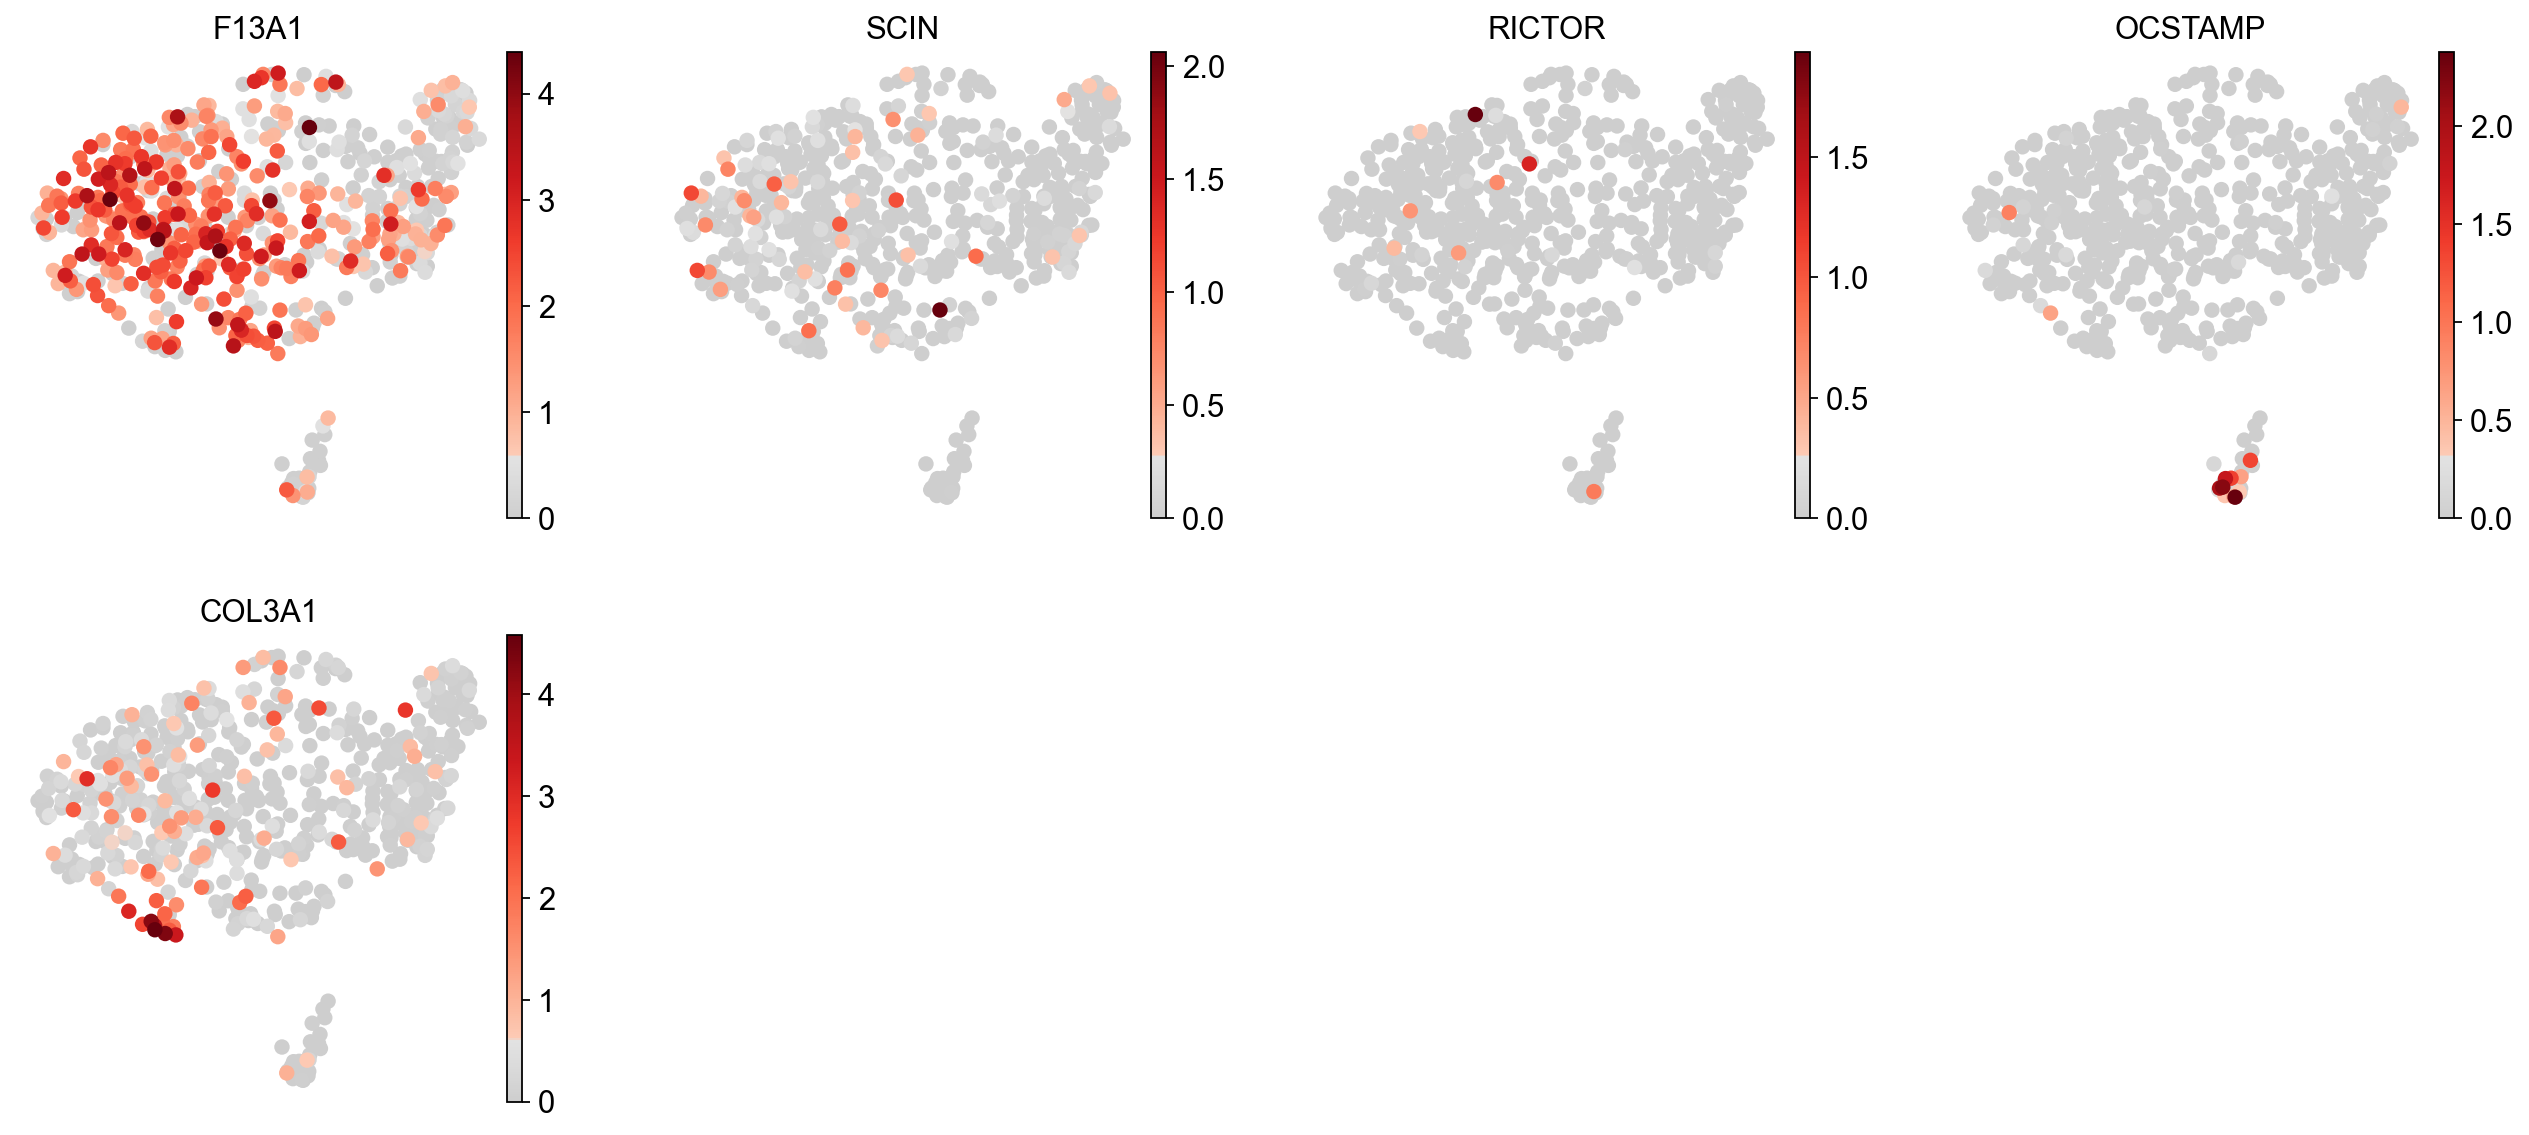

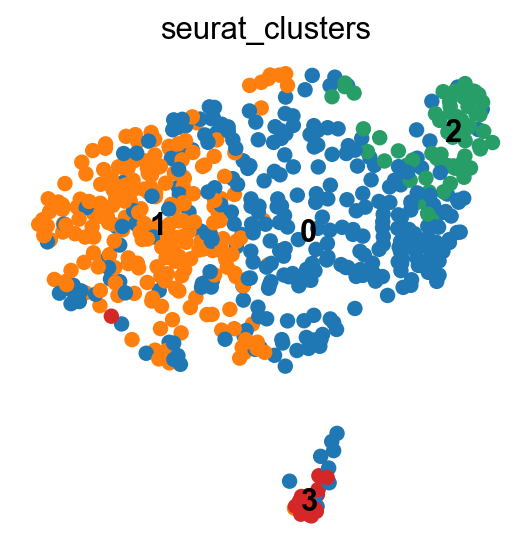

In [23]:
sc.pl.umap(AxoMac, color=['F13A1','SCIN','RICTOR','OCSTAMP','COL3A1'], legend_loc="on data", use_raw=False, color_map = mymap, frameon=False)
sc.pl.umap(AxoMac, color=['seurat_clusters'], legend_loc="on data", use_raw=False, color_map = mymap, frameon=False)


In [24]:
# old_to_new = {
#     '0':'Activated',
#     '1':'Circulating',
#     '2':'Activated',
#     '3':'Activated2',
#     '4':'mTORC2',
#     '5':'Matrix remodeling',
#     '6':'Bone',
#     '7':'Circulating',

# }
# AxoMac.obs['cell types'] = (
#     AxoMac.obs['seurat_clusters']
#     .map(old_to_new)
#     .astype('category')
# )

In [25]:
AxoMac.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,SCT_snn_res.1,seurat_clusters,dataset,cellType,integrated_snn_res.0.4
pal1_01_A01,pal,177896.0,2921,217059.0,2916,4,0,Yu,Senescent,0
pal1_01_A17,pal,138990.0,2398,216259.0,2379,4,0,Yu,Senescent,0
pal1_01_A22,pal,421092.0,5408,209383.0,4718,1,1,Yu,Senescent,1
pal1_01_A18,pal,230810.0,4011,220244.0,4001,4,0,Yu,Senescent,0
pal2_01_B08,pal,280694.0,5004,221082.0,4986,4,0,Yu,Senescent,0
...,...,...,...,...,...,...,...,...,...,...
Blastema_377_02_P20,Blastema,1007647.0,2338,1265212.0,2302,1,0,Macrophage,NA,0
Blastema_378_02_P21,Blastema,1857106.0,2049,1215047.0,2046,0,0,Macrophage,NA,0
Blastema_379_02_P22,Blastema,1321607.0,2235,1243204.0,2196,0,0,Macrophage,NA,0
Blastema_380_02_P23,Blastema,952882.0,2746,1265844.0,2692,1,0,Macrophage,NA,0


In [26]:
# sc.pl.umap(AxoMac,
#            color=['cell types'],
#            outline_color = ('white'),
#            use_raw=False,
#            color_map = mymap,
#            frameon=False,
#            save='_Macro_cell_types.pdf'
#           )


In [27]:
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params)
# plt.rcParams.update({'axes.labelsize' : 40}) 

# gene_list = ['F13A1','SCIN','RICTOR','OCSTAMP','COL3A1']
# for gene in gene_list:
#     sc.pl.violin(AxoMac,
#                  gene, 
#                  'cell types',
#                  jitter=False,
#                  stripplot=False,
#                  linewidth=0,
#                  xlabel=None,
#                  xticks=None,
#                  save='_macro_'+gene+'.pdf'
#                 )

In [28]:
set(AxoMac.obs.index.str.replace("_.+$","",regex=True).str.replace("[0-9]","",regex=True))

{'Blastema', 'late', 'mid', 'pal'}

In [29]:
AxoMac.obs["batch"]=AxoMac.obs.index.str.replace("_.._...$","",regex=True).str.replace("[0-9]","",regex=True)

In [30]:
# AxoMac.uns['cell types_colors']

In [31]:
AxoMac.obs['orig.ident']

pal1_01_A01                 pal
pal1_01_A17                 pal
pal1_01_A22                 pal
pal1_01_A18                 pal
pal2_01_B08                 pal
                         ...   
Blastema_377_02_P20    Blastema
Blastema_378_02_P21    Blastema
Blastema_379_02_P22    Blastema
Blastema_380_02_P23    Blastema
Blastema_381_02_P24    Blastema
Name: orig.ident, Length: 623, dtype: category
Categories (4, object): ['Blastema', 'late', 'mid', 'pal']

In [32]:
AxoMac.obs['orig.ident'].cat.set_categories(['Blastema', 'mid', 'late', 'pal'], inplace=True)

In [33]:
common = pd.read_csv("../Bulk/common_UPgenes_symbolANDid.csv")
common.head()

,gene_id,symbol
0,AMEX60DD002123,AMEX60DD002123
1,AMEX60DD002209,AMEX60DD002209
2,AMEX60DD003570,AMEX60DD003570
3,AMEX60DD004025,AMEX60DD004025
4,AMEX60DD004026,AMEX60DD004026


In [34]:
sc.tl.score_genes(AxoMac, 
                      common.symbol, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='CommonBulkScore', 
                      random_state=0, copy=False, use_raw=False)

computing score 'CommonBulkScore'
    finished: added
    'CommonBulkScore', score of gene set (adata.obs).
    450 total control genes are used. (0:00:00)


... storing 'batch' as categorical


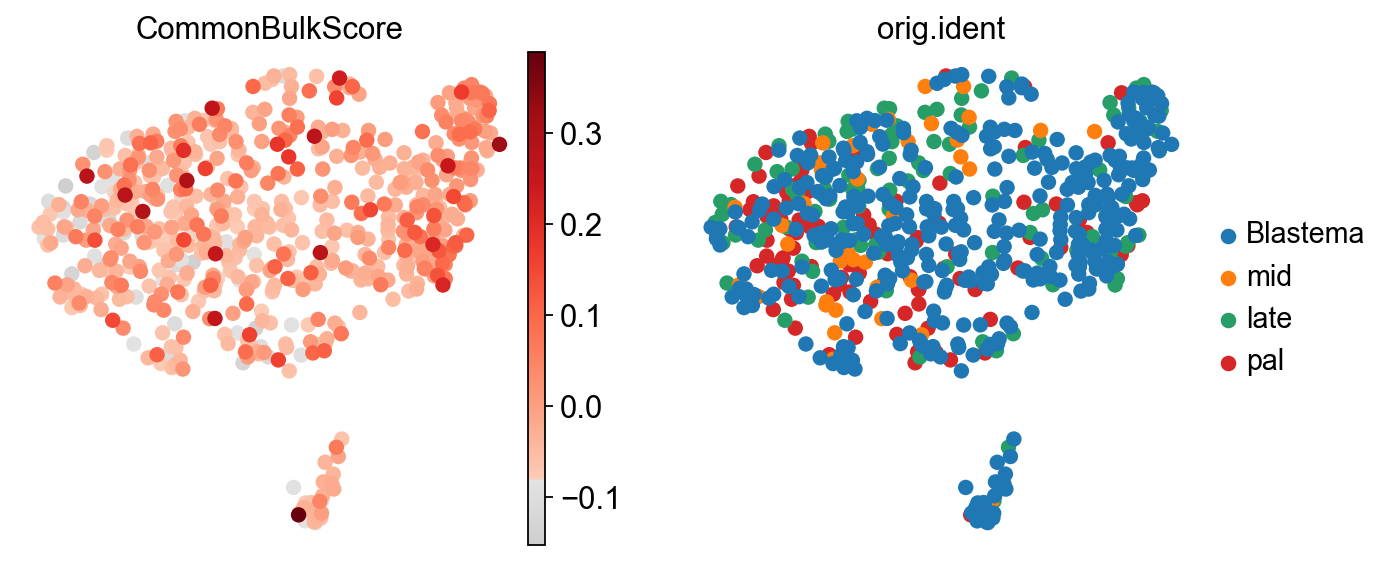

In [35]:
sc.pl.umap(AxoMac, color=['CommonBulkScore','orig.ident'],  use_raw=False, color_map = mymap, frameon=False)


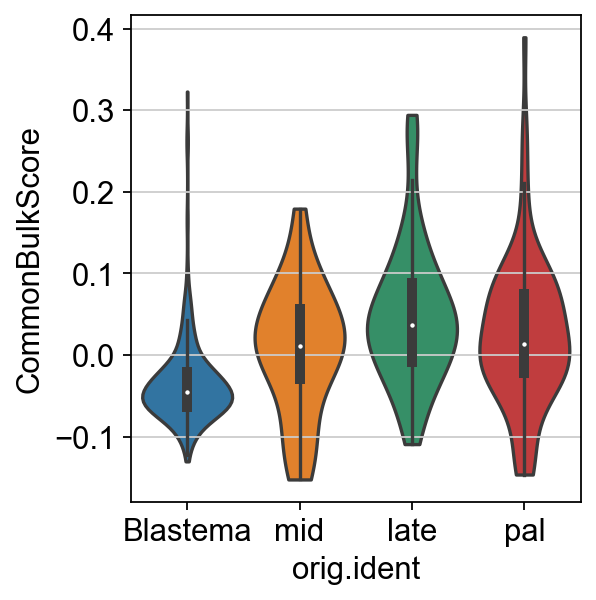

In [36]:
sc.pl.violin(AxoMac, ['CommonBulkScore'], groupby='orig.ident' , stripplot=False, inner='box')
# sc.pl.violin(AxoMac, ['CommonBulkScore'], groupby='dataset' , stripplot=False, inner='box')

In [37]:
AxoMac.uns['dataset_colors'] = ["#D5D5D5", '#d62728']

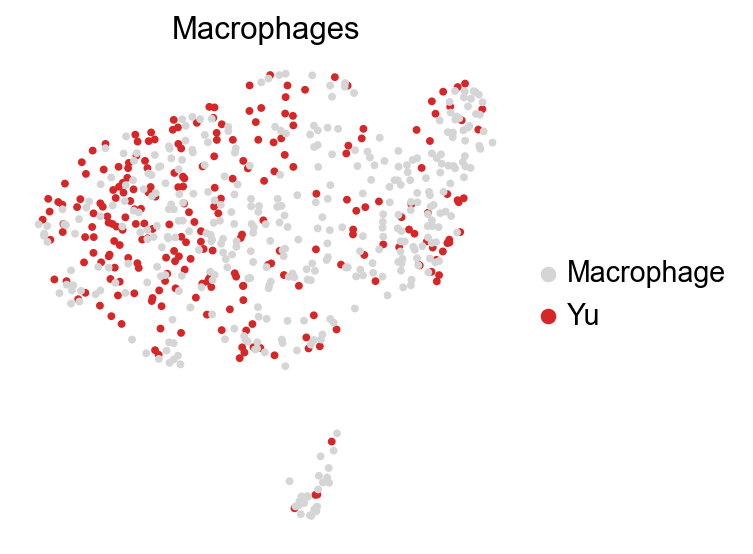

In [38]:
sc.pl.umap(AxoMac, color=['dataset'], size = 50, title="Macrophages", frameon=False, save="Macro")

In [39]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]

In [40]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in AxoMac.var_names]

In [41]:
sc.tl.score_genes_cell_cycle(AxoMac, s_genes=s_genes, g2m_genes=g2m_genes)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    387 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    515 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


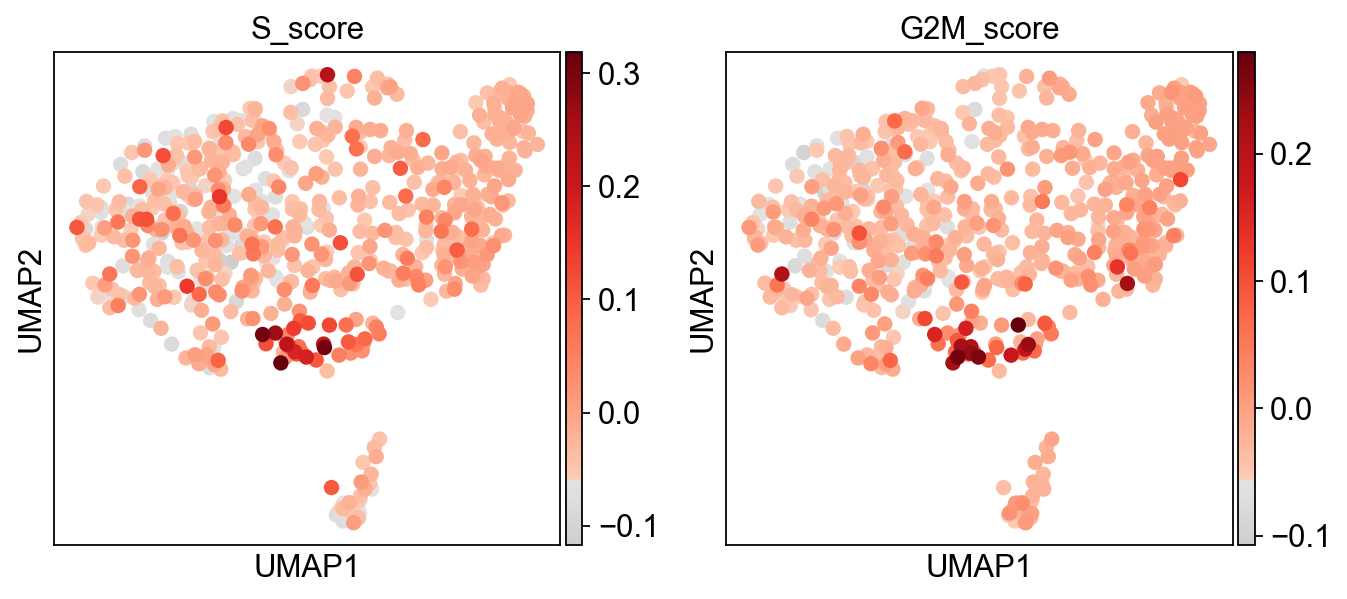

In [42]:
sc.pl.umap(AxoMac, color=['S_score', 'G2M_score'], use_raw=False, color_map = mymap)

In [43]:
sc.tl.embedding_density(AxoMac, basis='umap', groupby='phase')

computing density on 'umap'
--> added
    'umap_density_phase', densities (adata.obs)
    'umap_density_phase_params', parameter (adata.uns)


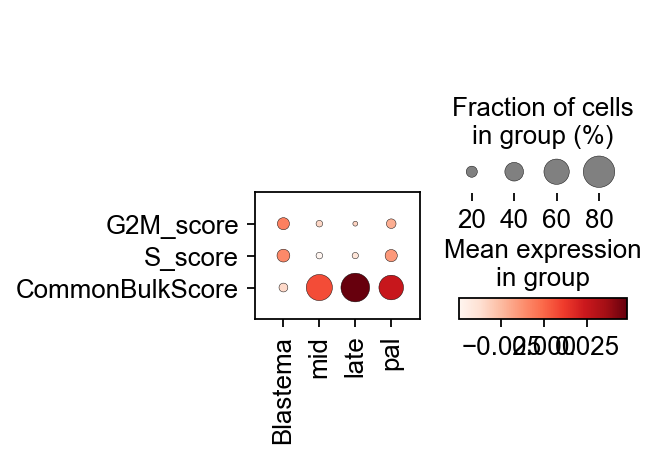

In [44]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['G2M_score', 'S_score', 'CommonBulkScore'],
              swap_axes=True,
              save="_Macro_compare_CellCycle_commonScore"
             )

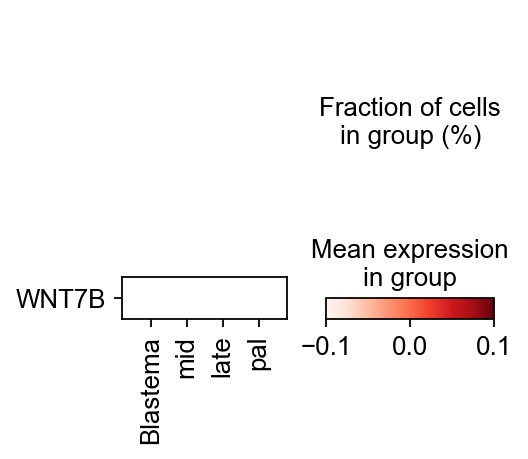

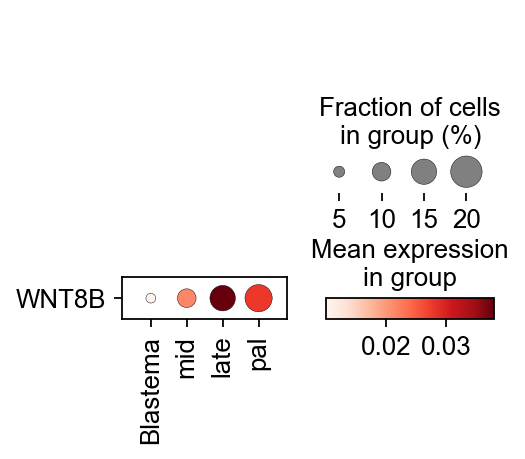

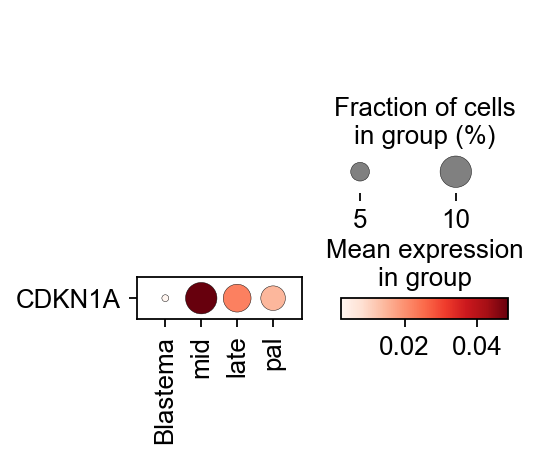

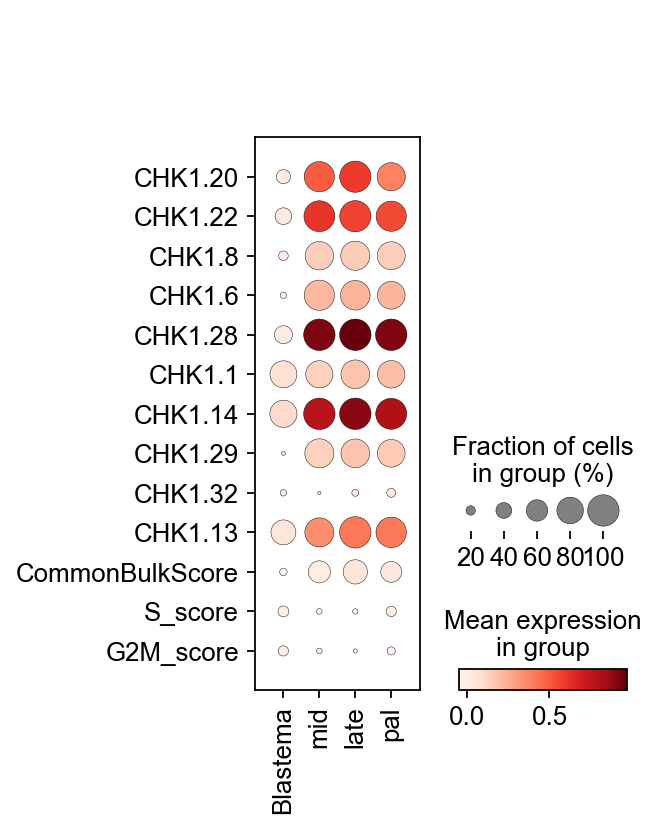

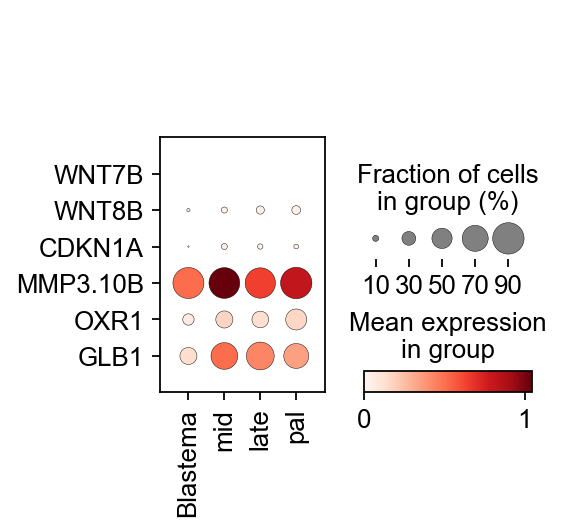

In [45]:

sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['WNT7B'],
              swap_axes=True,
              save="_WNT7B"
             )
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['WNT8B'],
              swap_axes=True,
              save="_WNT8B"
             )
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['CDKN1A'],
              swap_axes=True,
              save="_CDKN1A"
             )

sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['CHK1.20', 'CHK1.22','CHK1.8','CHK1.6','CHK1.28','CHK1.1','CHK1.14',
                       'CHK1.29','CHK1.32','CHK1.13','CommonBulkScore','S_score', 'G2M_score'],
              swap_axes=True,
              save="_Macro_senescenceScore"
             )
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['WNT7B', 'WNT8B', 'CDKN1A', 'MMP3.10B', 'OXR1', 'GLB1'],
              swap_axes=True, dendrogram=False,
              save="_Macro_WNTpathway"
             )

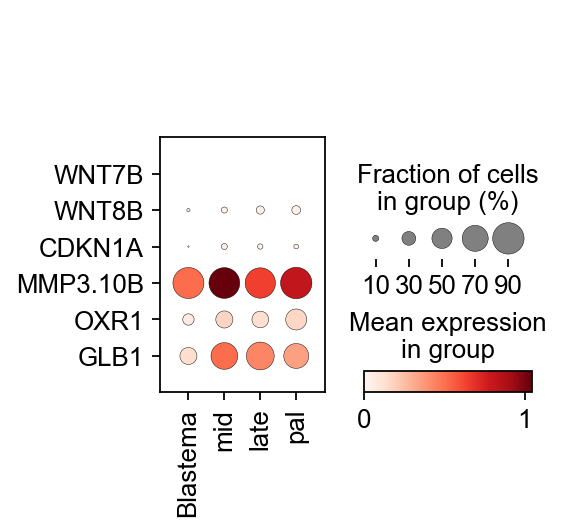

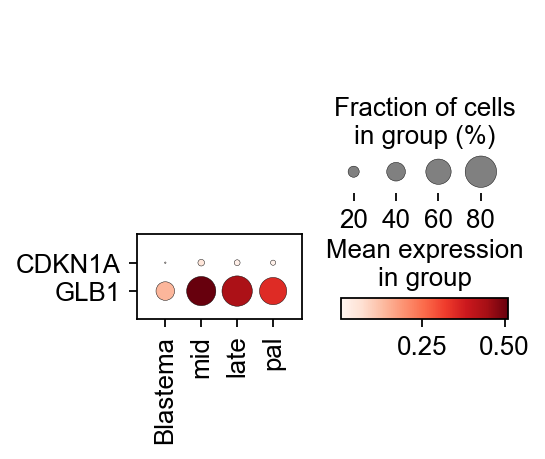

In [46]:

sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['WNT7B', 'WNT8B', 'CDKN1A', 'MMP3.10B', 'OXR1', 'GLB1'],
              swap_axes=True, dendrogram=False,
              save="_Macro_WNTpathway"
             )

sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['CDKN1A', 'GLB1'],
              swap_axes=True, dendrogram=False
             )

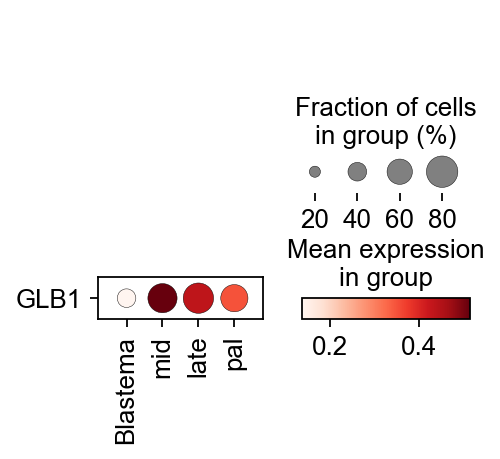

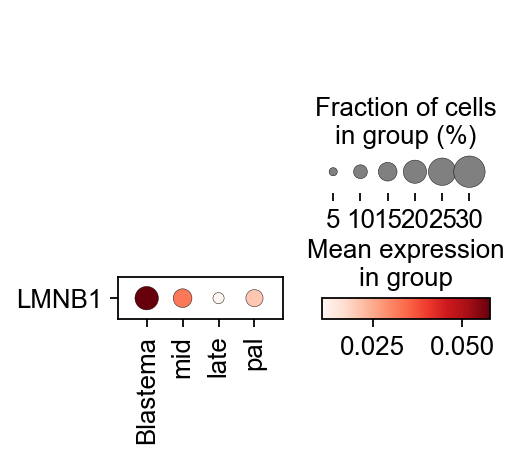

In [50]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['GLB1'],
              swap_axes=True, dendrogram=False,
              save="_Macro_GLB1"
             )
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['LMNB1'],
              swap_axes=True, dendrogram=False,
              save="_Macro_LMNB1"
             )

Gene sets

In [87]:
SETS = pd.read_csv('../gene_sets/5ETS.txt', names=['5ETS'])
E2Ftargets = pd.read_csv('../gene_sets/E2Ftargets.txt', names=['E2Ftargets'])
Inflammatory = pd.read_csv('../gene_sets/Inflammatory.txt', names=['Inflammatory'])
ITS1 = pd.read_csv('../gene_sets/ITS1.txt', names=['ITS1'])
Lysosome = pd.read_csv('../gene_sets/Lysosome.txt', names=['Lysosome'])
NOTCH = pd.read_csv('../gene_sets/NOTCH.txt', names=['NOTCH'])
RibosomalProcessing = pd.read_csv('../gene_sets/Ribosome.txt', names=['Ribosome'])
rRNA = pd.read_csv('../gene_sets/rRNA_transcripts.txt', names=['rRNA'])
SASP = pd.read_csv('../gene_sets/SASP.txt', names=['SASP'])

In [48]:
SETS_genes = [x for x in AxoMac.var_names if x in list(SETS.iloc[:,0])]
len(SETS_genes)

60

In [49]:
sc.tl.score_genes(AxoMac, 
                      SETS_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='5ETS_score', 
                      random_state=0, copy=False, use_raw=False)

computing score '5ETS_score'
    finished: added
    '5ETS_score', score of gene set (adata.obs).
    699 total control genes are used. (0:00:00)


In [50]:
E2Ftargets_genes = [x for x in AxoMac.var_names if x in list(E2Ftargets.iloc[:,0])]
len(E2Ftargets_genes)

164

In [51]:
sc.tl.score_genes(AxoMac, 
                      E2Ftargets_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='E2Ftargets_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'E2Ftargets_score'
    finished: added
    'E2Ftargets_score', score of gene set (adata.obs).
    643 total control genes are used. (0:00:00)


In [52]:
Inflammatory_genes = [x for x in AxoMac.var_names if x in list(Inflammatory.iloc[:,0])]
len(Inflammatory_genes)

438

In [53]:
sc.tl.score_genes(AxoMac, 
                      Inflammatory_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='Inflammatory_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'Inflammatory_score'
    finished: added
    'Inflammatory_score', score of gene set (adata.obs).
    745 total control genes are used. (0:00:00)


In [54]:
ITS1_genes = [x for x in AxoMac.var_names if x in list(ITS1.iloc[:,0])]
len(ITS1_genes)

10

In [55]:
sc.tl.score_genes(AxoMac, 
                      ITS1_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='ITS1_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'ITS1_score'
    finished: added
    'ITS1_score', score of gene set (adata.obs).
    448 total control genes are used. (0:00:00)


In [56]:
Lysosome_genes = [x for x in AxoMac.var_names if x in list(Lysosome.iloc[:,0])]
len(Lysosome_genes)

91

In [57]:
sc.tl.score_genes(AxoMac, 
                      Lysosome_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='Lysosome_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'Lysosome_score'
    finished: added
    'Lysosome_score', score of gene set (adata.obs).
    598 total control genes are used. (0:00:00)


In [58]:
NOTCH_genes = [x for x in AxoMac.var_names if x in list(NOTCH.iloc[:,0])]
len(NOTCH_genes)

131

In [59]:
sc.tl.score_genes(AxoMac, 
                      NOTCH_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='NOTCH_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'NOTCH_score'
    finished: added
    'NOTCH_score', score of gene set (adata.obs).
    748 total control genes are used. (0:00:00)


In [81]:
RibosomalProcessing_genes = [x for x in AxoMac.var_names if x in list(RibosomalProcessing.iloc[:,0])]
len(RibosomalProcessing_genes)

250

In [82]:
sc.tl.score_genes(AxoMac, 
                      RibosomalProcessing_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='RibosomalProcessing_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'RibosomalProcessing_score'
    finished: added
    'RibosomalProcessing_score', score of gene set (adata.obs).
    594 total control genes are used. (0:00:00)


In [72]:
rRNA_genes = [x for x in AxoMac.var_names if x in list(rRNA.iloc[:,0])]
len(rRNA_genes)

16

In [73]:
sc.tl.score_genes(AxoMac, 
                      rRNA_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='rRNA_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'rRNA_score'
    finished: added
    'rRNA_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)


In [88]:
SASP_genes = [x for x in AxoMac.var_names if x in list(SASP.iloc[:,0])]
len(SASP_genes)

64

In [89]:
sc.tl.score_genes(AxoMac, 
                      SASP_genes, 
                      ctrl_size=50, 
                      gene_pool=None, 
                      n_bins=25, 
                      score_name='SASP_score', 
                      random_state=0, copy=False, use_raw=False)

computing score 'SASP_score'
    finished: added
    'SASP_score', score of gene set (adata.obs).
    650 total control genes are used. (0:00:00)


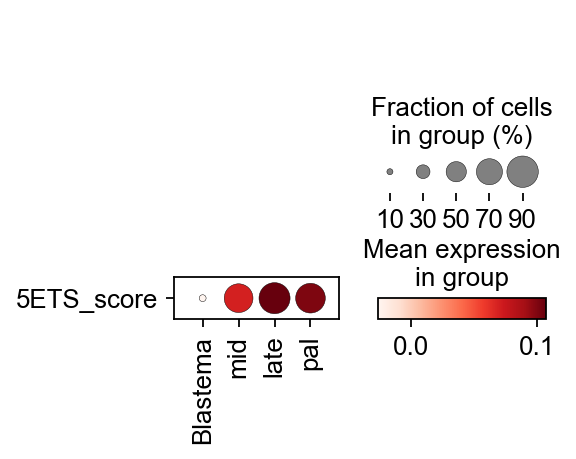

In [62]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names="5ETS_score",
              swap_axes=True, dendrogram=False,
              save="_Macro_5ETS"
             )

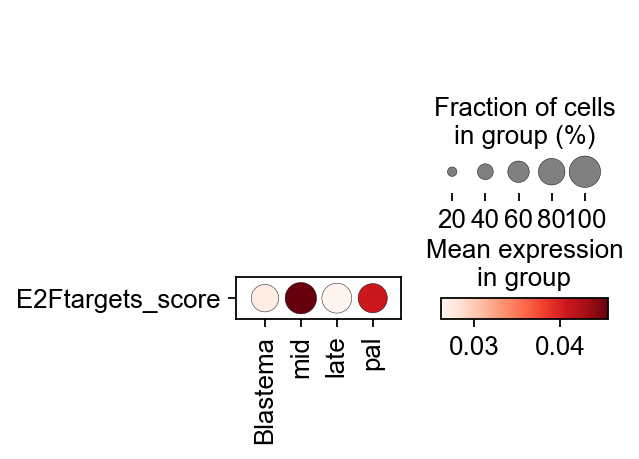

In [63]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names="E2Ftargets_score",
              swap_axes=True, dendrogram=False,
              save="_Macro_E2Ftargets"
             )

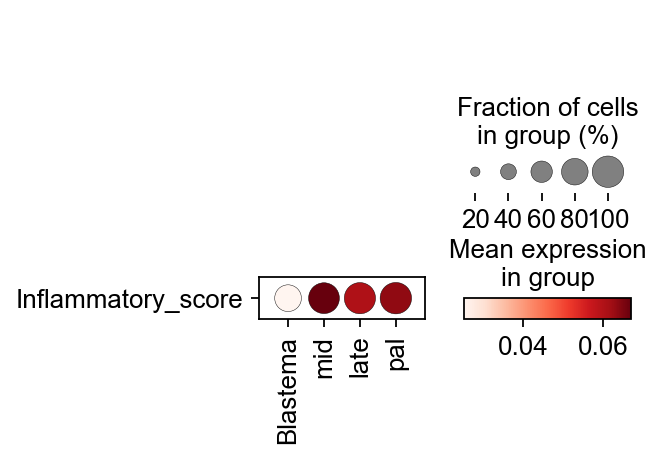

In [64]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names="Inflammatory_score",
              swap_axes=True, dendrogram=False,
              save="_Macro_Inflammatory"
             )

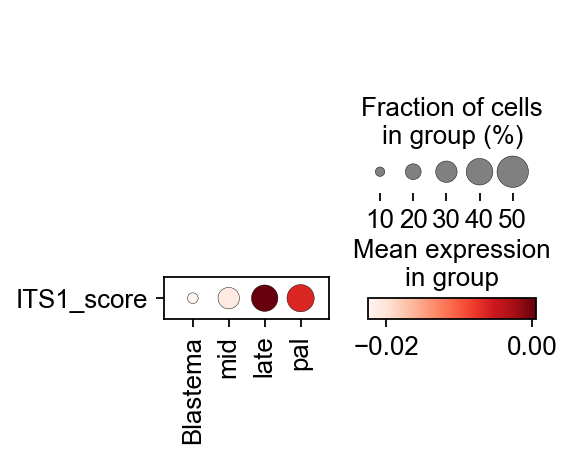

In [65]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names="ITS1_score",
              swap_axes=True, dendrogram=False,
              save="_Macro_ITS1"
             )

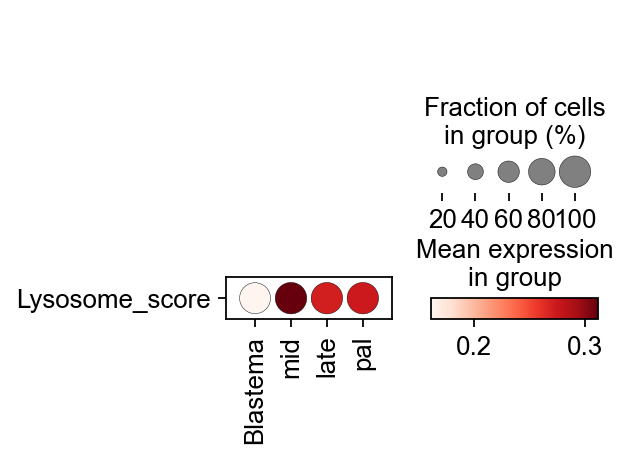

In [66]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names="Lysosome_score",
              swap_axes=True, dendrogram=False,
              save="_Macro_Lysosome"
             )

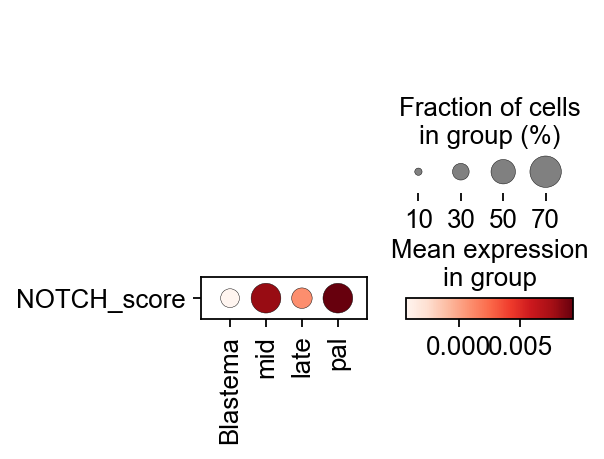

In [67]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names="NOTCH_score",
              swap_axes=True, dendrogram=False,
              save="_Macro_NOTCH"
             )

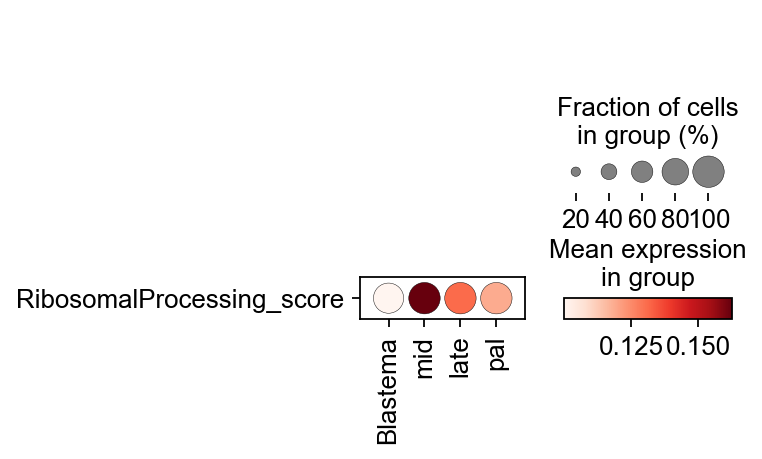

In [85]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names="RibosomalProcessing_score",
              swap_axes=True, dendrogram=False,
              save="_Macro_Ribosome"
             )

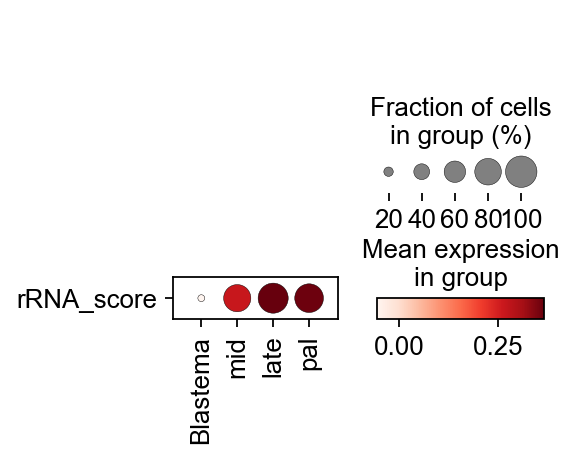

In [74]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names="rRNA_score",
              swap_axes=True, dendrogram=False,
              save="_Macro_Ribosome"
             )

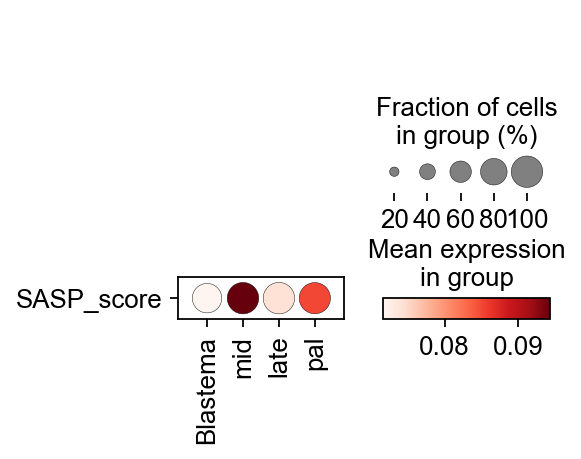

In [90]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names="SASP_score",
              swap_axes=True, dendrogram=False,
              save="_Macro_SASP"
             )

In [69]:
AxoMac

AnnData object with n_obs × n_vars = 623 × 52730
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'seurat_clusters', 'dataset', 'cellType', 'integrated_snn_res.0.4', 'batch', 'CommonBulkScore', 'S_score', 'G2M_score', 'phase', 'umap_density_phase', '5ETS_score', 'E2Ftargets_score', 'Inflammatory_score', 'ITS1_score', 'Lysosome_score', 'NOTCH_score', 'Ribosome_score'
    var: 'name'
    uns: 'seurat_clusters_colors', 'neighbors', 'draw_graph', 'log1p', 't-test', 'wilcoxon', 'orig.ident_colors', 'dataset_colors', 'umap_density_phase_params'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa'
    obsp: 'distances', 'connectivities'

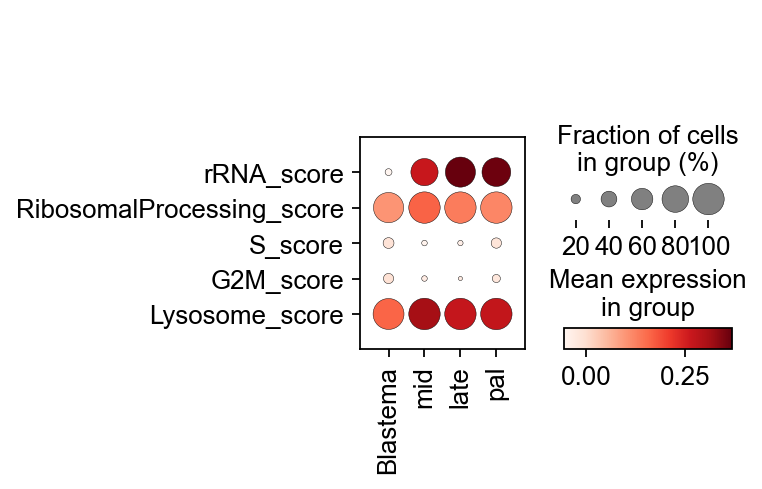

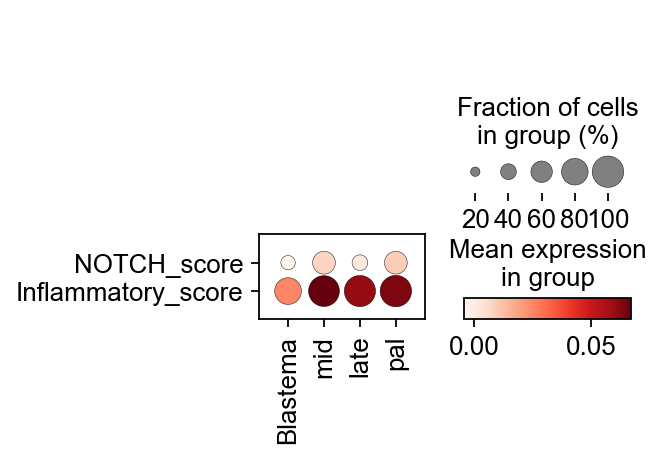

In [86]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['rRNA_score', 'RibosomalProcessing_score', 
                                                  'S_score',
                                                  'G2M_score',
                                                  'Lysosome_score'],
              swap_axes=True, dendrogram=False,
              save="_Macro_all_sets"
             )

sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['NOTCH_score','Inflammatory_score'],
              swap_axes=True, dendrogram=False,
              save="_Macro_NotchInfl"
             )

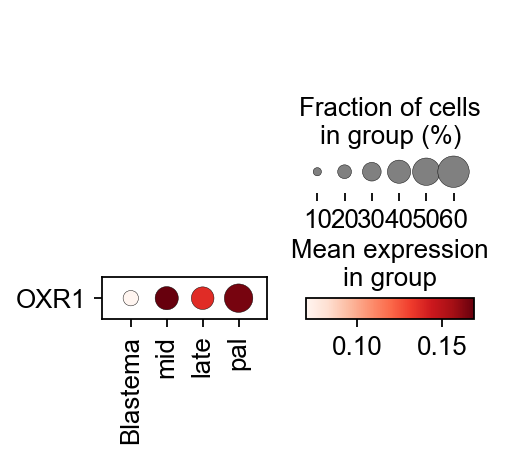

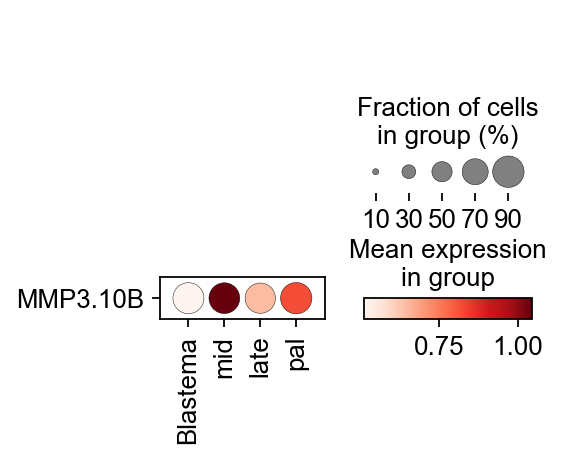

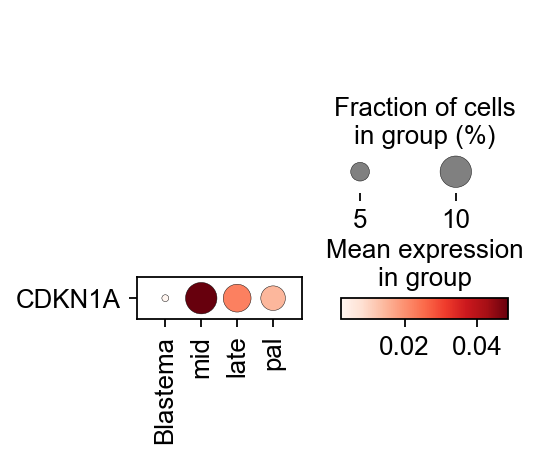

In [77]:
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['OXR1'],
              swap_axes=True, dendrogram=False,
              save="_Macro_OXR1"
             )
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['MMP3.10B'],
              swap_axes=True, dendrogram=False,
              save="_Macro_MMP3-10B"
             )
sc.pl.dotplot(AxoMac,groupby="orig.ident", var_names=['CDKN1A'],
              swap_axes=True, dendrogram=False,
              save="_Macro_CDKN1A"
             )